In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy import special
import scipy.stats as st
import healpy as hp
import os
import imageio
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', module='healpy' )
import logging
logging.getLogger('healpy').setLevel(logging.CRITICAL)

In [2]:
def temporalPlot(pt,Nt,gaps):
    tbeg, tend = 1717.6256+(np.linspace(1666.4384902198801, 2704.3655735533684, 2) + 2455197.5 - 2457023.5 - 0.25)*4
    bins = np.linspace(tbeg,tend,Nt+1)
    centres = 0.5*(bins[1:] + bins[:-1])

    plt.plot(centres,pt)
    
    if type(gaps) != bool:
        for start,end in zip(gaps['tbeg'].values,gaps['tend'].values):
            plt.fill_between([start,end],y1=[-2,-2],y2=[2,2],color='lightblue',lw=0.0)
    plt.ylim([0,1.02])
   
    plt.xlabel(r"OBMT (revolutions)")
    plt.ylabel(r"$p_t$")
    plt.title(r"Temporal Detection Efficiency")
    plt.xticks(np.arange(1000,5251,1000))

    plt.yticks(np.arange(0.0,1.01,0.1))
    # plt.grid(axis='both',which='both',lw=0.3,color='lightgrey',zorder=0)
    # plt.savefig(directory+'plot_pt.png',dpi=300,facecolor='w',bbox_inches='tight')
  

In [3]:
def temporalResiduals(pt,pt_true):
    
    deltas = np.absolute(pt - pt_true) + 1e-8
   # deltas[np.isinf(deltas) or np.isnan(deltas) or deltas < -8] = -8
    logDeltas = np.log10(deltas)
    plt.hist(logDeltas,bins = 100, histtype='step',log = True)
    
    plt.xlabel(r"$\log_{10}\left( \left|p_t^{true} - p_t^{recovered} \right|\right)$")
    plt.ylabel(r"Counts")
    
    lowerLim = np.floor(min(logDeltas))
    plt.xlim([lowerLim,0])
    plt.title(r"Temporal Residuals")

In [4]:
def round_sig(x, sig=2):
    if abs(x) > 0:
        return round(x, sig-int(np.floor(np.log10(abs(x))))-1)
    else:
        return 0
def spatialPlot(pml,titleText,fig,manualScaling = False,hasCBar = True):
    mi = 0
    ma = 1
    unit = r"$p_{ml}$"
    if manualScaling:
        v = round_sig(max(abs(pml)),2)
        mi = 0
        ma = v
        unit = r"$|p_{ml}^{true} - p_{ml}^{recovered}|$"
    hp.graticule(dmer=180,dpar=180,alpha=0);
    hp.mollview(pml, xsize = 500,nest=False, hold=True, min=mi,max=ma,title =titleText, cmap='viridis', cbar=hasCBar,coord=['C','G'],notext=True,unit=unit)
    

In [5]:
def readFile(directory,file):
    try:
        params = pd.read_csv(directory+'OptimizerProperties.dat',skipinitialspace=True,index_col=0,sep=" =",header=None,engine='python').transpose()
        Nt = int(params['Nt'])
        Nm = int(params['Nm'])
        Nl = int(params['Nl'])
    except:
        params = pd.read_csv(directory+'Optimiser_Properties.dat',skipinitialspace=True,sep=",")
        Nt = int(params['Nt'])
        Nm = int(params['Nm'])
        Nl = int(params['Nl'])
    alpha = 0.5*np.log(2)
    a = -3.0
    if type(file) == int:
        file = "TempPositions/TempPosition" + str(file) + "_TransformedParameters.dat"
    xt = pd.read_csv(directory+file,header=None)[0][:Nt].values
    pt = special.expit(xt)
    xml = np.reshape(pd.read_csv(directory+file,header=None)[0][Nt:Nt+Nm*Nl].values,(Nl,Nm)).T
    pml = np.exp(-2.0*alpha*np.exp(-xml))
    pml[xml<a] = np.exp(-2.0*alpha*(1.0-xml[xml<a]+a)*np.exp(-a))
    return [pt,pml,Nm]

In [6]:
def baseGif(saveName,truedirectory,tempdirectory,start,stop):
    
    trueFile = "True_TransformedParameters.dat"
    [truePt,truePml] = readFile(truedirectory,trueFile)
    names = []
    fig = plt.figure(figsize=(8,8))
    for i in range(start,stop,gap):
        print(i)
        [pt,pml] = readFile(directory,i)

        baseComparisonPlot(fig,truePt,truePml,pt,pml,False)

        tempName = saveName +"_temp" + str(i) + ".png"
        names.append(tempName)
        plt.savefig(tempName)
        fig.clf()
    plt.close(fig)
 
    saveName = saveName + ".gif"
    delay = 2
    with imageio.get_writer(saveName,mode = 'I') as writer:
        for name in names:
            print(name)
            image = imageio.imread(name)
            for k in range(0,delay):
                writer.append_data(image)

            os.remove(name)

In [7]:
def magnitudePlot(mag,trueMag):
    Nm = len(mag[0])
    Nm_t = len(trueMag[0])
    bins = np.arange(1.7,23.05,0.1)
    f_alpha = 0.2
    if Nm_t > 1:
        g = 0.5*(bins[1:]+bins[:-1])[:Nm_t]
    
        plt.plot(g,trueMag[0])
 
        plt.fill_between(g,trueMag[1],trueMag[2],alpha = f_alpha)
    else:
        plt.plot([bins[0],bins[-1]],[trueMag[0],trueMag[0]])
    if Nm > 1:
        
        g = 0.5*(bins[1:]+bins[:-1])[:Nm]
        
        plt.plot(g,mag[0])
        plt.fill_between(g,mag[1],mag[2],alpha = f_alpha)
    else:
        plt.plot([bins[0],bins[-1]],[mag[0],mag[0]])
    plt.legend(["True Value","Recovered Value"],loc="lower center")
    plt.xlabel(r"$G$, Visual Magnitude")
    plt.ylabel(r"Sky-Averaged Probability")
    plt.title("Magnitude Probability")

In [8]:
def interval(magSet):
    mu = np.mean(magSet)
    f = np.sort(magSet)
    N = len(magSet)
    tenthPercentile = int(np.floor(N/10))
    lower = f[tenthPercentile]
    upper = f[N - tenthPercentile]
    return [mu,lower,upper]
    
    
def processMagnitude(pml_mag):
    Nm = len(pml_mag)
    pml = pml_mag[0]
    mag = [ [], [], [] ]
    [mu,low,up] = interval(pml_mag[0])
    mag[0] = [mu]
    mag[1] = [low]
    mag[2] = [up]
    
    for m in range(1,Nm):
        pml += pml_mag[m]
        [mu,low,up] = interval(pml_mag[m])
        mag[0].append(mu)
        mag[1].append(low)
        mag[2].append(up)
    pml /= Nm
    return [pml, mag]

In [9]:
def baseComparisonPlot(fig,truept,truepml,pt,pml,gaps,Nm_true,Nm):
 
    ##temporal plot
   
    nx = 2
    ny = 3
    
    magPlot = False
    if max(Nm_true,Nm) > 1:
        ny += 1
        magPlot = True
    gs = GridSpec(ny,nx)

   
    
    [apml, mag] = processMagnitude(pml)
    [tpml, trueMag] = processMagnitude(truepml)

    nside_true = hp.get_nside(tpml)
    nside_approx = hp.get_nside(apml)
   
    if nside_true != nside_approx:
        if nside_true > nside_approx:
            tpml = hp.ud_grade(tpml,nside_approx)
        else:
            apml = hp.ud_grade(apml,nside_true)
    
    ##spatial plot
    fig.add_subplot(gs[ny-2,0])
    spatialPlot(tpml,"True Spatial Efficiency",fig)
    fig.add_subplot(gs[ny-2,1])
    spatialPlot(apml,"Recovered Spatial Efficiency",fig)
    fig.add_subplot(gs[ny-1,1])
    spatialPlot(abs(tpml-apml),"Spatial Residuals",fig,True)
    

    fig.add_subplot(gs[0,:])
    temporalPlot(truept,len(truept),False)

    temporalPlot(pt,len(pt),False)
    plt.legend(["True Value","Recovered Value"],loc="lower right")
    

    fig.add_subplot(gs[ny-1,0])
    temporalResiduals(pt,truept)
    
    if magPlot:
        fig.add_subplot(gs[1,:])
        magnitudePlot(mag,trueMag)
def multiMagPlot(fig,truepml,pml):
    rows= 2
    
    nx = 2 * rows
    ny = 5
    
    outer_gs = GridSpec(ny,rows)
    gs = GridSpec(ny,nx)
    
    
    bins = np.arange(1.7,23.05,0.1)
    g_true = 0.5*(bins[1:]+bins[:-1])[:len(truepml)]
    g = 0.5*(bins[1:]+bins[:-1])[:len(pml)]
    
    Nm_true_grid = np.linspace(0,len(truepml)-1,rows*ny+1)
    Nm_grid = np.linspace(0,len(pml)-1,rows*ny+1)
    for i in range(0,ny):
        print("Plotting row ", i+1 ," out of ", ny)
        hasCBar = False
        if i == ny - 1:
            hasCBar = True
        for j in range(0,rows):
            m_id = i*rows + j
            true_id_lower = int(Nm_true_grid[m_id])
            true_id_upper = int(Nm_true_grid[m_id+1])
            id_lower = int(Nm_grid[m_id])
            id_upper = int(Nm_grid[m_id+1])
            
            tpml = truepml[true_id_lower]
            for m in range(true_id_lower+1,true_id_upper):
                tpml += truepml[m]
            tpml /= (true_id_upper - true_id_lower)
            
            apml = pml[id_lower]
            for m in range(id_lower+1,id_upper):
                apml += pml[m]
            apml /= (id_upper - id_lower)
            
            
            nside_true = hp.get_nside(tpml)
            nside_approx = hp.get_nside(apml)

            if nside_true != nside_approx:
                if nside_true > nside_approx:
                    tpml = hp.ud_grade(tpml,nside_approx)
                else:
                    apml = hp.ud_grade(apml,nside_true)
            
            t = r'$\mathbf{' + f'{g[id_lower]:.2f}<= g < {g[id_upper]:.2f}' + r"}$"
            outer = fig.add_subplot(outer_gs[i,j])
            outer.axis('off')
            plt.title(t)
            
            fig.add_subplot(gs[i,2*j])
           
            
            t1 = None
            t2 = None
           
          
            spatialPlot(tpml,t1,fig,False,hasCBar)
            
            fig.add_subplot(gs[i,2*j+1])
            spatialPlot(apml,t2,fig,False,hasCBar)

In [10]:
def baseFrame(saveName,truedirectory,tempdirectory,frame):
    print("Reading in true data")
    trueFile = "True_TransformedParameters.dat"
    [truePt,truePml,Nm_true] = readFile(truedirectory,trueFile)
    # [truePt,truePml] = readFile(tempdirectory,frame - 10)
    fig = plt.figure(figsize=(10,12),dpi = 200)

    
    print("Reading in recovered data")
    [pt,pml,Nm] = readFile(tempdirectory,frame)

    print("Beginning Plotting routine")
    baseComparisonPlot(fig,truePt,truePml,pt,pml,False,Nm_true,Nm)

    # fig.tight_layout()
    print("Saving Plot")
    plt.subplots_adjust( hspace=0.4)
    plt.savefig(saveName,bbox_inches='tight',transparent=False,facecolor='w',dpi=200)
    plt.show()
    fig.clf()
    plt.close(fig)
    print("Complete")
def multiMagFrame(saveName,truedirectory,tempdirectory,frame):
    print("Reading in true data")
    trueFile = "True_TransformedParameters.dat"
    [truePt,truePml,Nm_true] = readFile(truedirectory,trueFile)
    # [truePt,truePml] = readFile(tempdirectory,frame - 10)
    fig = plt.figure(figsize=(15,10),dpi = 200)

    
    print("Reading in recovered data")
    [pt,pml,Nm] = readFile(tempdirectory,frame)

    print("Beginning plotting routine")
    multiMagPlot(fig,truePml,pml)

    print("Saving plot")
    # fig.tight_layout()
    plt.subplots_adjust( hspace=0.1)
    plt.savefig(saveName,bbox_inches='tight',transparent=False,facecolor='w',dpi=200)
    plt.show()
    fig.clf()
    plt.close(fig)
    print("Complete")
    

In [11]:
def fullSuite(usingCurrent = True,combo = ["flat","gaps","galaxy","full"]):
    dataDir = "../../../Data/TestSets/"
    directory = "../../../CodeOutput/TestRuns/"
    final = "FinalPosition_TransformedParameters.dat"
    current = "TempPositions/TempPosition_TransformedParameters.dat"

    simple = ["flat","gaps"]
    mags = ["galaxy","full"]
    
    sets = [simple,mags]
    
    mode = final
    if usingCurrent:
        mode = current
    
    for set in sets:
        
        for model in set:
            if model in combo:
                print("========= " + model + " model ============")
                fullDataDir = dataDir + model + "/"
                fullSimDir = directory + model + "/"
                baseFrame(model+".png",fullDataDir,fullSimDir,mode)
                
                if model in mags:
                     multiMagFrame(model + "_mag.png",fullDataDir,fullSimDir,final)

In [12]:
# fullSuite(True, combo = ["gaps","full"])

Reading in true data
Reading in recovered data
Beginning Plotting routine
Saving Plot


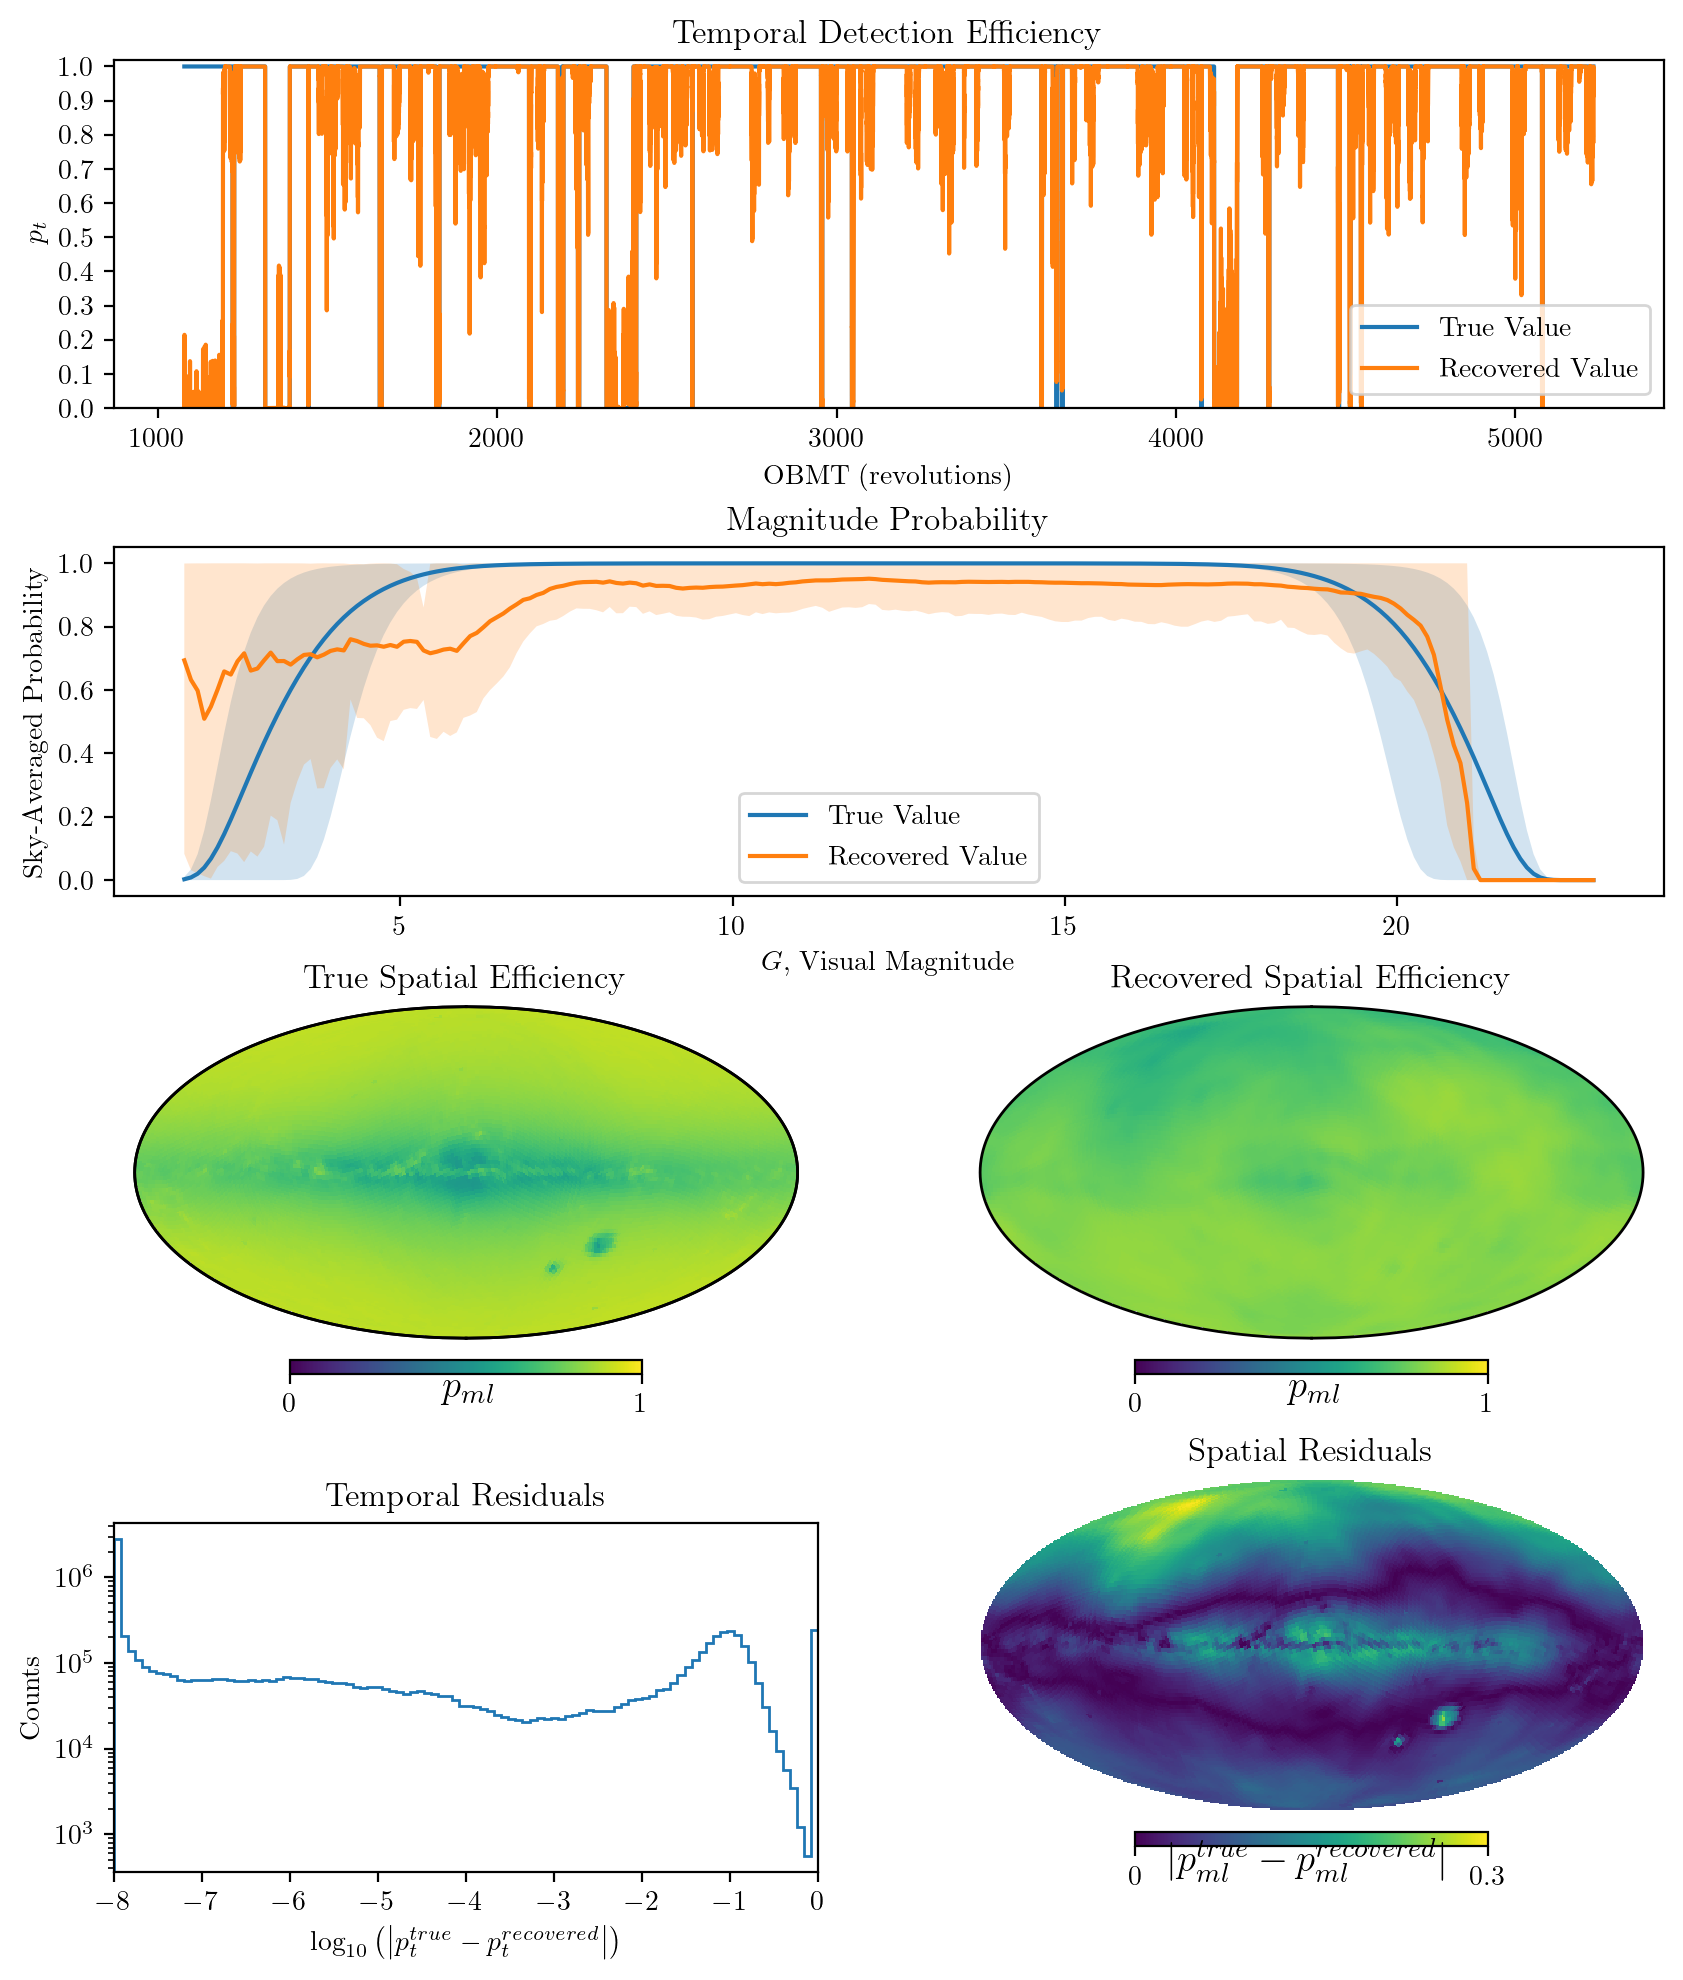

Complete


In [15]:
directory = "../../../CodeOutput/Production_BurnIn2/"
final = "FinalPosition_TransformedParameters.dat"
current = "TempPositions/TempPosition170_TransformedParameters.dat"
dataDir = "../../../Data/TestSets/full/"
fullSimDir = directory
baseFrame("test.png",dataDir,fullSimDir,current)

Reading in true data
Reading in recovered data
Beginning plotting routine
Plotting row  1  out of  5
Plotting row  2  out of  5
Plotting row  3  out of  5
Plotting row  4  out of  5
Plotting row  5  out of  5
Saving plot


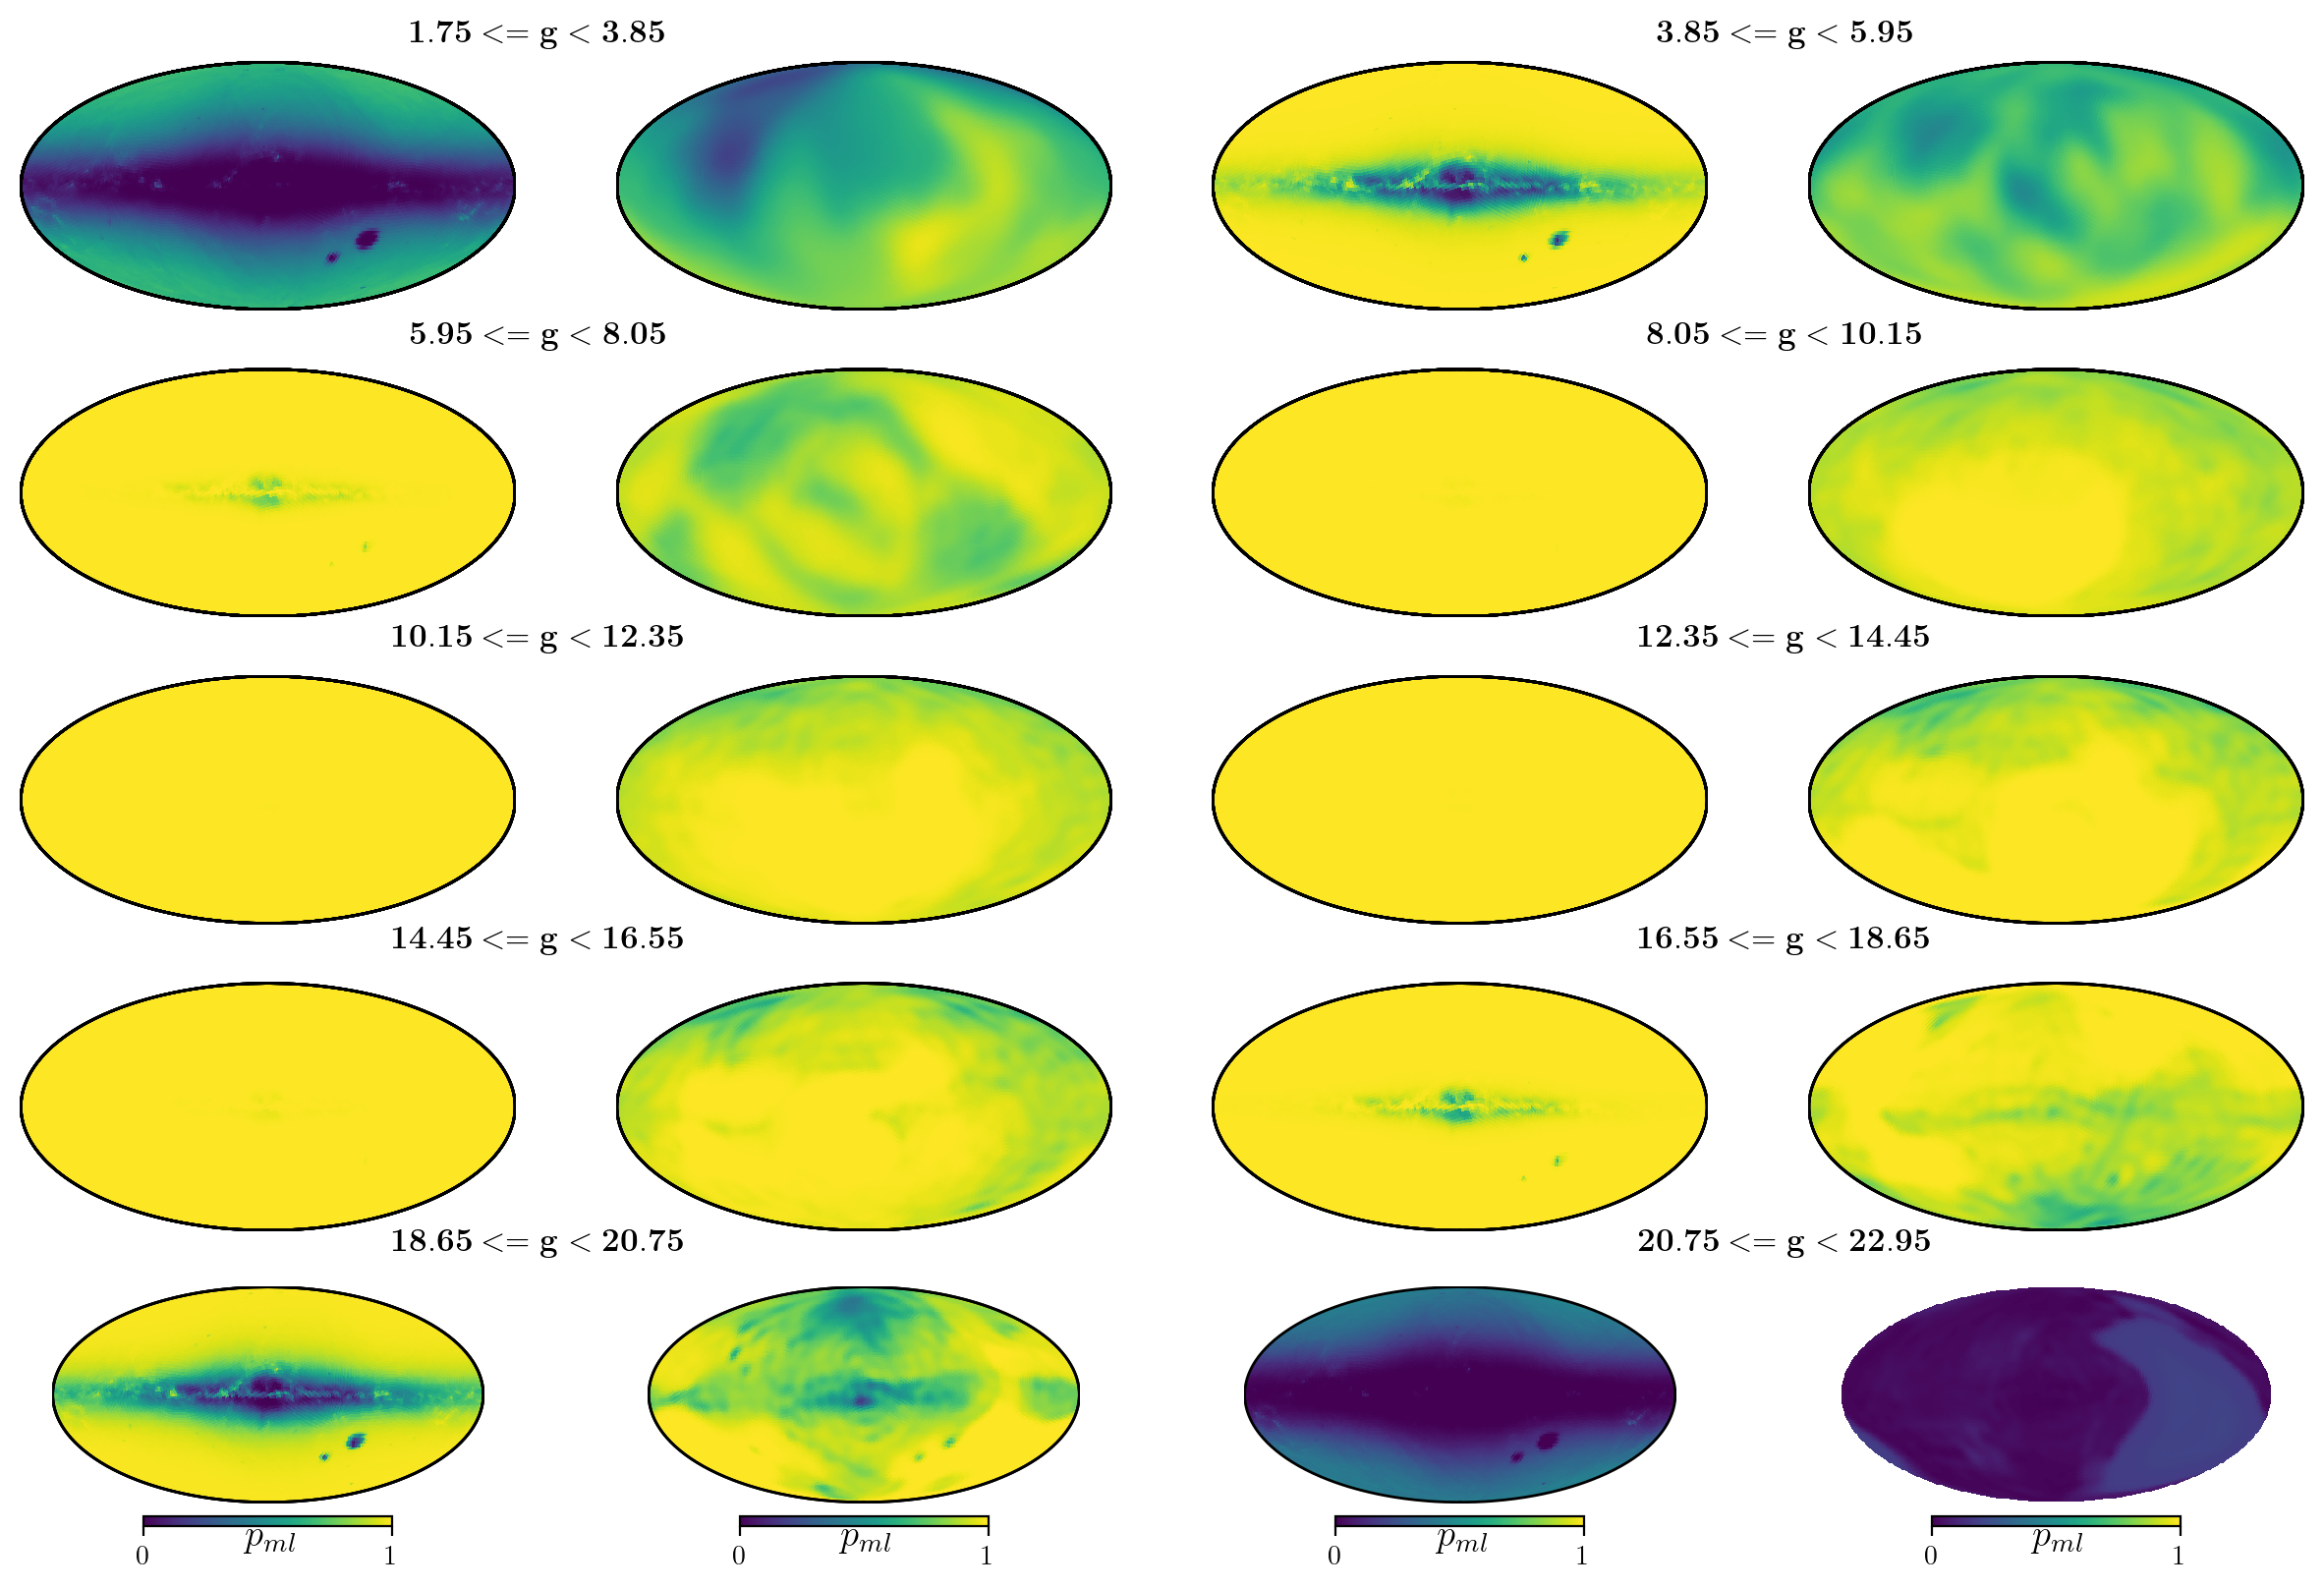

Complete


In [16]:
 multiMagFrame("test_mag.png",dataDir,fullSimDir,current)